In [ ]:
import time
start = time.time()

### Prepare Dependencies

In [ ]:
!pip install transformers -qq
!pip install datasets jiwer -qq
!pip install wandb -qq
!pip install gdown -qq
!pip install nvidia-ml-py3 -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm
# from tqdm.notebook import tqdm
import shutil
import re
import warnings
warnings.filterwarnings("ignore")
import nvidia_smi
import os
from IPython.display import clear_output

# Data Augmentation
import random
import numbers
import math
from torchvision.transforms import Compose

# Training
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from transformers import TrOCRProcessor
from torch.utils.data import DataLoader
from transformers import VisionEncoderDecoderModel
from datasets import load_metric
import wandb
from transformers import AdamW

In [ ]:
RETRAIN = False
CUDA = torch.cuda.is_available()
NUM_AUGMENTATION = 5
MODEL_CKPT = "microsoft/trocr-large-stage1"
BATCH_SIZE = 4
EPOCHS = 8
LR = 1e-6
AMOUNT_TRAIN_DATA = 1
AMOUNT_TEST_DATA = 1
print(CUDA)

True


In [ ]:
# Cek GPU
gpu_memory = 0
if CUDA:
    nvidia_smi.nvmlInit()
    deviceCount = nvidia_smi.nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
        info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
        gpu_memory = info.free
print("GPU Memory (free):", gpu_memory)

GPU Memory (free): 15832514560


In [ ]:
# Cek Working directory
wd = os.getcwd()
os.chdir(wd)
print(wd)

/content


In [ ]:
if not os.path.exists("CRAFT-pytorch"):
    !git clone https://github.com/maulairfani/CRAFT-pytorch.git
    %cd CRAFT-pytorch
    # Pretrained model Craft text detection
    !gdown 1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ -q
    %cd {wd}

Cloning into 'CRAFT-pytorch'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 66 (delta 3), reused 7 (delta 3), pack-reused 56
Receiving objects: 100% (66/66), 1.69 MiB | 9.59 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
os.environ['WANDB_API_KEY'] = "635114e88ef363d32d797643d14d46fadf38927f"
os.environ["WANDB_SILENT"] = "true"

### Read the Data

In [ ]:
# Downloading the zip files
!gdown 1oPOjYd4_76Oiewbes5wk8WR9E5Xq3e4g -q
# !gdown 1t3uQsE1wOnl5ok7ZyQr7KzatzsJWoJ4y -q

In [ ]:
if not os.path.exists("train") or not os.path.exists("test"):
    with zipfile.ZipFile("Data Train for BDC 2023 - Penyisihan.zip", 'r') as zip_ref:
        zip_ref.extractall(".")

    with zipfile.ZipFile("Data Test for BDC 2023 - Penyisihan.zip", 'r') as zip_ref:
        zip_ref.extractall(".")

    os.rename('Data Train for BDC 2023 - Penyisihan', 'train')
    os.rename('Data Test for BDC 2023 - Penyisihan', 'test')

In [ ]:
df = pd.read_csv("train/DataTrain.csv", sep=";").drop("Unnamed: 0", axis=1)
df = df.head(int(AMOUNT_TRAIN_DATA * len(df)))
df.tail()

Vehicleregistrationplate        NameofFile
795                 B1677EJC  DataTrain796.png
796                  B1743VO  DataTrain797.png
797                 AD1416YD  DataTrain798.png
798                 AB5419TN  DataTrain799.png
799                 AB6315SE  DataTrain800.png

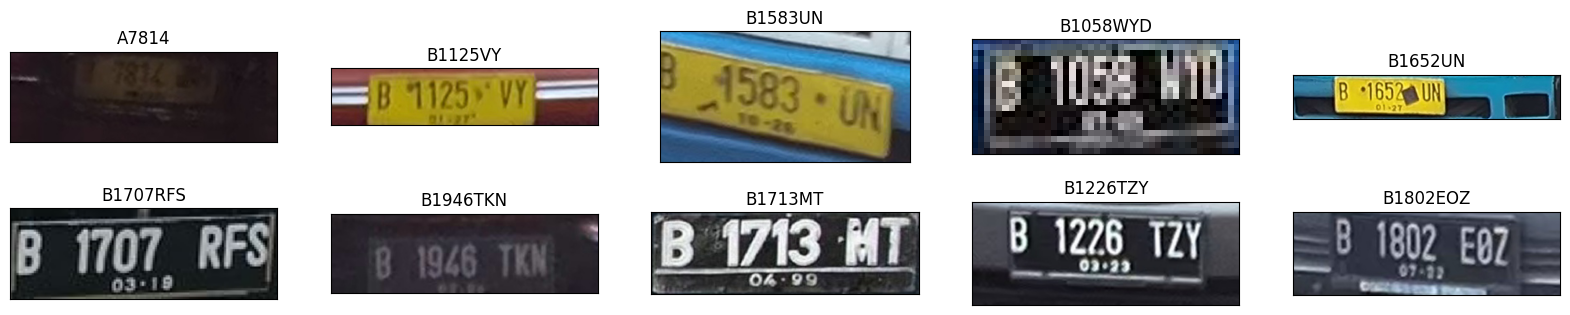

In [ ]:
# first 10 train images
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(10, 5, i+1)
    i = np.random.randint(1, len(df))
    img = Image.open(f"train/DataTrain{i}.png")
    plt.title(df["Vehicleregistrationplate"].iloc[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

### Perspective Transformation

Metode text detection menggunakan CRAFT (Character-Region Awareness For Text detection), yang didapatkan dari repository berikut:

https://github.com/maulairfani/CRAFT-pytorch

In [ ]:
%%time
os.chdir(wd)
result_folder = "img_preprocessed/perspective_correction/train/"
os.makedirs(result_folder, exist_ok=True)
os.chdir(os.path.join(wd, "CRAFT-pytorch"))

# Detecting text
!python test.py --trained_model craft_mlt_25k.pth \
    --test_folder ../train \
    --cuda {CUDA} \
    --result_folder ../{result_folder} \
    --low_text 0.1 \
    --link_threshold 0

os.chdir(wd)

Loading weights from checkpoint (craft_mlt_25k.pth)
elapsed time : 31.846760034561157s
CPU times: user 444 ms, sys: 44.1 ms, total: 488 ms
Wall time: 46.8 s


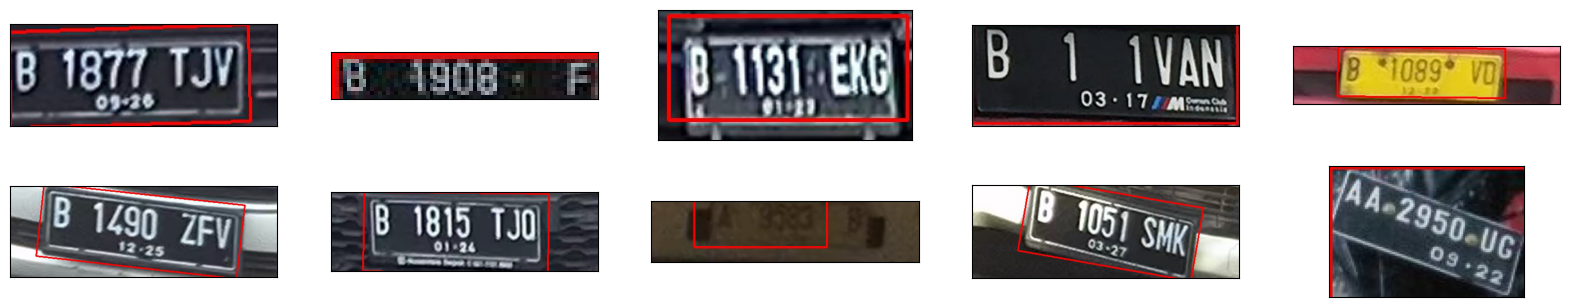

In [ ]:
# Result
result_folder = "./img_preprocessed/perspective_correction/train"
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(10, 5, i+1)
    idx = np.random.randint(1, len(df))
    img = Image.open(f"{result_folder}/res_DataTrain{idx}.jpg")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

In [ ]:
def apply_perspective_transform(image, source_points, target_points, desired_width=200, desired_height=80):
    perspective_matrix = cv2.getPerspectiveTransform(source_points, target_points)
    transformed_image = cv2.warpPerspective(np.array(image), perspective_matrix, (desired_width, desired_height))
    return transformed_image

def process_single_image(image_number, result_folder="img_preprocessed/perspective_correction/train"):
    with open(os.path.join(result_folder, f"res_DataTrain{image_number}.txt"), "r") as f:
        content = f.read()

    if content == "":
        return image_number

    coordinate_set = content.split('\n')[0]
    coordinates = coordinate_set.split(',')
    x1, y1, x2, y2, x3, y3, x4, y4 = map(int, coordinates)

    source_points = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    desired_width = 200
    desired_height = 80
    target_points = np.float32([[0, 0], [desired_width, 0], [desired_width, desired_height], [0, desired_height]])

    img = cv2.imread(f"train/DataTrain{image_number}.png")
    transformed_image = apply_perspective_transform(img, source_points, target_points)

    output_path = os.path.join(result_folder, f"DataTrain{image_number}_transformed.png")
    cv2.imwrite(output_path, transformed_image)
    return output_path

no_text_detected = []
for i in tqdm(range(len(df)), desc="Perspective Correction"):
    out = process_single_image(i + 1)
    if out == i + 1:
        no_text_detected.append(i + 1)
print("Tidak ditemukan teks pada gambar:", no_text_detected)

Perspective Correction: 100%|██████████| 800/800 [00:03<00:00, 258.88it/s]

Tidak ditemukan teks pada gambar: [1, 26, 69, 108, 136, 140, 185, 255, 257, 294, 394, 416, 435, 525, 527, 544, 571, 603, 656, 750, 761, 799, 800]


In [ ]:
# Clean up directory
result_folder = "img_preprocessed/perspective_correction/train/"
os.makedirs(f"{result_folder}/masks", exist_ok=True)
os.makedirs(f"{result_folder}/transformed", exist_ok=True)
os.makedirs(f"{result_folder}/res", exist_ok=True)
os.makedirs(f"{result_folder}/points", exist_ok=True)

for f in os.listdir(result_folder):
    if os.path.isfile(os.path.join(result_folder, f)):
        source = os.path.join(result_folder, f)
        if "mask" in f:
            shutil.move(source, os.path.join(result_folder, "masks", f))
        elif "transformed" in f:
            shutil.move(source, os.path.join(result_folder, "transformed", f))
        elif "txt" in f:
            shutil.move(source, os.path.join(result_folder, "points", f))
        else:
            shutil.move(source, os.path.join(result_folder, "res", f))

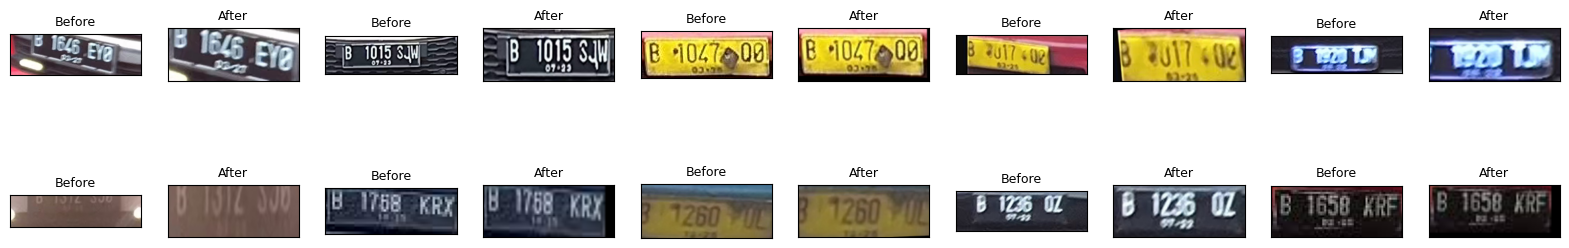

In [ ]:
# Result
plt.figure(figsize=(20, 20))
i = 0
while i <= 18:
    plt.subplot(10, 10, i+1)
    idx = np.random.randint(1, len(df))
    if idx not in no_text_detected:
        img = Image.open(f"train/DataTrain{idx}.png").convert("RGB")
        plt.title("Before", fontsize=9)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)

        plt.subplot(10, 10, i+2)
        dir = "img_preprocessed/perspective_correction/train/transformed"
        img = Image.open(os.path.join(dir, f"DataTrain{idx}_transformed.png")).convert("RGB")
        plt.title("After", fontsize=9)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)

        i += 2

### Text Segmentation

In [ ]:
%%time
os.chdir(wd)
result_folder = "img_preprocessed/text_segmentation/train/"
os.makedirs(result_folder, exist_ok=True)
test_folder = "img_preprocessed/perspective_correction/train/transformed"

os.chdir(os.path.join(wd, "CRAFT-pytorch"))

# Detecting text
!python test.py --trained_model craft_mlt_25k.pth \
    --test_folder ../{test_folder} \
    --cuda {CUDA} \
    --result_folder ../{result_folder} \
    --low_text 0.2 \
    --link_threshold 0.8

os.chdir(wd)

Loading weights from checkpoint (craft_mlt_25k.pth)
elapsed time : 13.777434825897217s
CPU times: user 221 ms, sys: 19.7 ms, total: 240 ms
Wall time: 21.8 s


In [ ]:
# Clean up directory
result_folder = "img_preprocessed/text_segmentation/train/"
os.makedirs(f"{result_folder}/masks", exist_ok=True)
os.makedirs(f"{result_folder}/res", exist_ok=True)
os.makedirs(f"{result_folder}/points", exist_ok=True)

for f in os.listdir(result_folder):
    if os.path.isfile(os.path.join(result_folder, f)):
        source = os.path.join(result_folder, f)
        if "mask" in f:
            f = f.replace("_transformed", "")
            shutil.move(source, os.path.join(result_folder, "masks", f))
        elif "txt" in f:
            f = f.replace("_transformed", "")
            shutil.move(source, os.path.join(result_folder, "points", f))
        else:
            f = f.replace("_transformed", "")
            shutil.move(source, os.path.join(result_folder, "res", f))

In [ ]:
def extract_coordinates_from_file(file_path):
    coordinates = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                coords = [int(coord) for coord in line.split(',')]
                coordinates.append(coords)
    return coordinates

def calculate_center_point(coordinates):
    x_values = coordinates[::2]
    y_values = coordinates[1::2]

    min_x = min(x_values)
    max_x = max(x_values)
    min_y = min(y_values)
    max_y = max(y_values)

    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2

    return center_x, center_y

def crop_images(image_path, coordinates):
    image = Image.open(image_path)
    cropped_images = []
    for i, coords in enumerate(coordinates):
        x1, y1, x2, y2, x3, y3, x4, y4 = coords
        cropped_image = image.crop((x1, y1, x3, y3))
        cropped_images.append(cropped_image)
    return cropped_images

In [ ]:
result_folder = "img_preprocessed/text_segmentation/train/crops"
os.makedirs(result_folder, exist_ok=True)

center_x, center_y = [], []
file_name = []
for i in range(len(df)):
    i += 1
    if i not in no_text_detected:
        coor = extract_coordinates_from_file(f"img_preprocessed/text_segmentation/train/points/res_DataTrain{i}.txt")
        cropped_images = crop_images(f"img_preprocessed/perspective_correction/train/transformed/DataTrain{i}_transformed.png", coor)
        shutil.copy(f"img_preprocessed/perspective_correction/train/transformed/DataTrain{i}_transformed.png",
                    os.path.join(result_folder, f"DataTrain{i}_0.png"))
        for idx, img in enumerate(cropped_images):
            img.save(os.path.join(result_folder, f"DataTrain{i}_{idx+1}.png"))

            file_name.append(f"DataTrain{i}_{idx+1}.png")
            c_x, c_y = calculate_center_point(coor[idx])
            center_x.append(c_x), center_y.append(c_y)

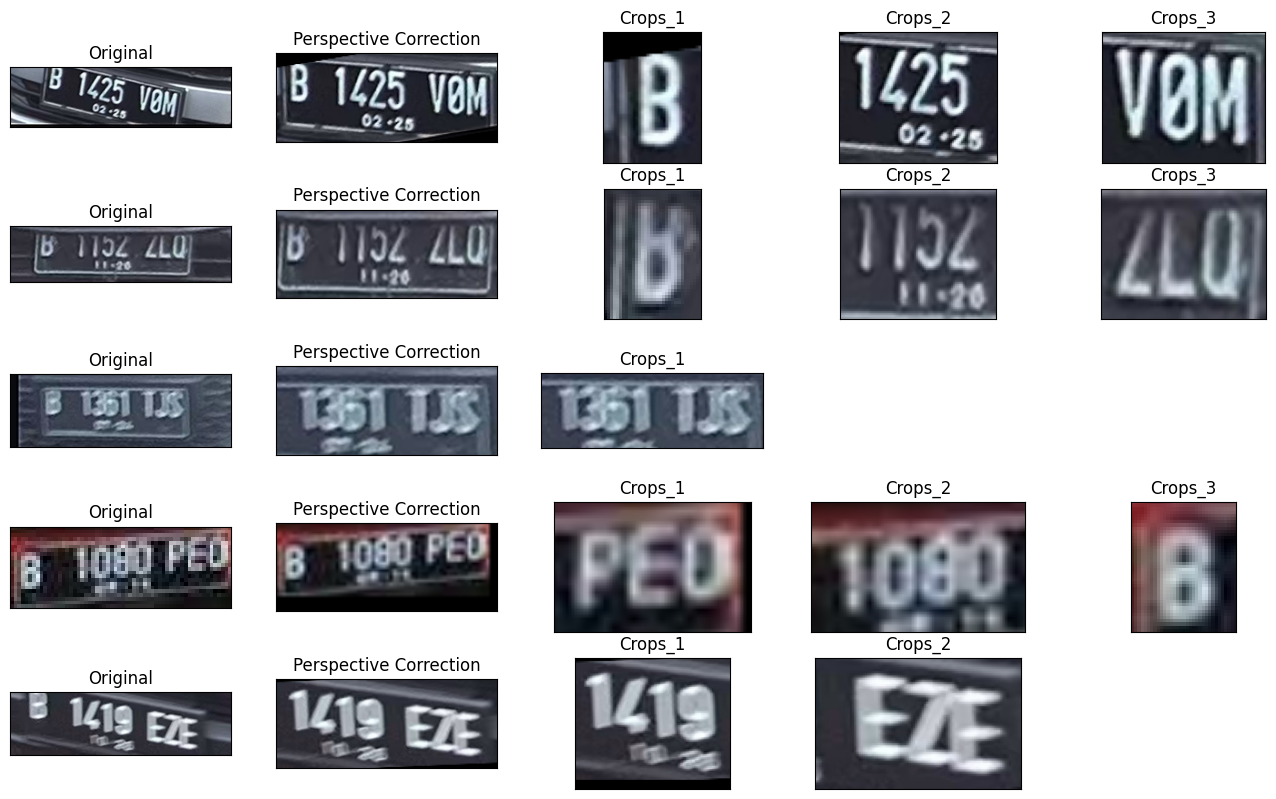

In [ ]:
# Result
plt.figure(figsize=(20, 20))
i = 1
while i < 30:
    idx = np.random.randint(1, len(df))
    if idx not in no_text_detected:
        plt.subplot(10, 6, i)
        img_ori = Image.open(f"train/DataTrain{idx}.png")
        plt.title("Original")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_ori)

        plt.subplot(10, 6, i+1)
        img_perspective_corrected = Image.open(f"img_preprocessed/perspective_correction/train/transformed/DataTrain{idx}_transformed.png")
        plt.title("Perspective Correction")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_perspective_corrected)

        for j in range(1, 5):
            img_path = f"img_preprocessed/text_segmentation/train/crops/DataTrain{idx}_{j}.png"
            if os.path.exists(img_path):
                plt.subplot(10, 6, i+j+1)
                img_crop = Image.open(img_path)
                plt.title(f"Crops_{j}")
                plt.xticks([])
                plt.yticks([])
                plt.imshow(img_crop)
            else:
                break
        i += 6

In [ ]:
df_coor = pd.DataFrame({"file_name": file_name, "x": center_x, "y": center_y})
os.makedirs("dataframe", exist_ok=True)
df_coor.to_csv("dataframe/df_coor.csv", index=False)
df_coor.tail()

file_name      x     y
2294  DataTrain797_4.png   93.0  61.0
2295  DataTrain798_1.png   29.0  33.0
2296  DataTrain798_2.png  100.0  33.0
2297  DataTrain798_3.png  170.0  34.0
2298  DataTrain798_4.png  101.5  63.0

### Collinearity Check

In [ ]:
df_coor = pd.read_csv("dataframe/df_coor.csv")

In [ ]:
def get_data(num, df=df_coor):
    return df[df["file_name"].str[9:-6].astype("int") == num]

def collinear(x1, y1, x2, y2, x3, y3):
    return x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)

def collinearity(coll_threshold=900):
    df_colls = df_coor.copy()
    bad_segmented, bad_collinearity = [], []

    nums = [i + 1 for i in range(len(df)) if i + 1 not in no_text_detected]
    for n in tqdm(nums, desc="Collinearity"):
        data = get_data(n)

        if len(data) < 3:
            bad_segmented.append(n)

        elif len(data) >= 3:
            x_values = data['x'].tolist()
            y_values = data['y'].tolist()

            comb, colls = [], []
            for i in range(len(x_values)):
                for j in range(i + 1, len(x_values)):
                    for k in range(j + 1, len(x_values)):
                        comb.append([i, j, k])
                        a = collinear(x_values[i], y_values[i], x_values[j], y_values[j], x_values[k], y_values[k])
                        colls.append(abs(a))

            idx_min = colls.index(min(colls))
            if colls[idx_min] > coll_threshold:
                bad_collinearity.append(n)

            idx_data = data.index
            drop = [e for e in idx_data if e not in [idx_data[d] for d in comb[idx_min]]]
            df_colls = df_colls.drop(drop, axis=0)

    return bad_segmented, bad_collinearity, df_colls

In [ ]:
bad_segmented, bad_collinearity, df_colls = collinearity(coll_threshold= 900)
len(bad_segmented), len(bad_collinearity)

Collinearity: 100%|██████████| 777/777 [00:01<00:00, 566.14it/s]


(166, 177)

In [ ]:
df_colls.tail()

file_name      x     y
2292  DataTrain797_2.png   82.5  30.5
2293  DataTrain797_3.png  167.5  49.0
2295  DataTrain798_1.png   29.0  33.0
2296  DataTrain798_2.png  100.0  33.0
2297  DataTrain798_3.png  170.0  34.0

### Concatinating Pieces

In [ ]:
def concat_image(num, dir="img_preprocessed/text_segmentation/train/crops"):
    data = get_data(num, df_colls).sort_values(by="x")
    list_img = [cv2.imread(os.path.join(dir, file)) for file in data["file_name"]]
    list_img = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in list_img]
    list_img = [cv2.resize(img, (int(80/img.shape[0] * img.shape[1]), 80)) for img in list_img]
    im_h = cv2.hconcat(list_img)
    return im_h

In [ ]:
result_folder = "img_preprocessed/image_concat/train"
os.makedirs(result_folder, exist_ok=True)
for i in tqdm(range(len(df)), desc="Concatenate image"):
    i += 1
    if i not in bad_segmented + bad_collinearity + no_text_detected:
        im_h = concat_image(i)
        cv2.imwrite(os.path.join(result_folder, f"DataTrain{i}.png"), im_h)

Concatenate image: 100%|██████████| 800/800 [00:01<00:00, 514.83it/s]


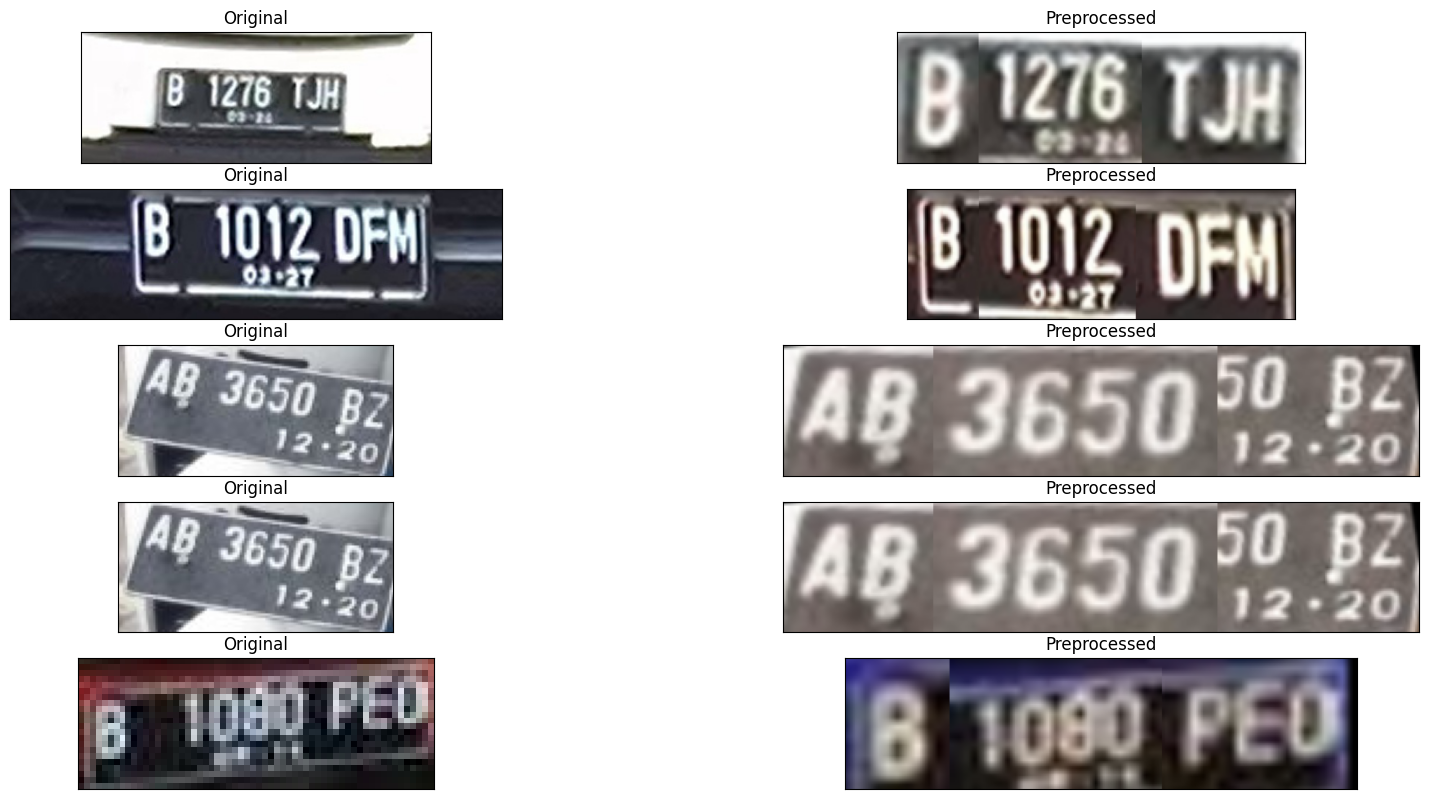

In [ ]:
# Visualize concatination result
concat_path = "img_preprocessed/image_concat/train"
plt.figure(figsize=(20, 20))
i = 1
while i <= 10:
    plt.subplot(10, 2, i)
    idx = np.random.choice(os.listdir(concat_path))[9:-4]
    img = Image.open(os.path.join("train", f"DataTrain{idx}.png"))
    plt.title("Original")
    plt.xticks([]), plt.yticks([])
    plt.imshow(img)

    plt.subplot(10, 2, i+1)
    img = Image.open(os.path.join(concat_path, f"DataTrain{idx}.png"))
    plt.title("Preprocessed")
    plt.xticks([]), plt.yticks([])
    plt.imshow(img)

    i+=2

### Image Augmentation

In [ ]:
file_name, text = [], []
perspective_path = "img_preprocessed/perspective_correction/train/transformed"
concat_path = "img_preprocessed/image_concat/train"

for i in tqdm(range(len(df))):
    if i+1 in no_text_detected+bad_segmented+bad_collinearity:
        file_name.append(os.path.join("train", f"DataTrain{i+1}.png"))
        text.append(df["Vehicleregistrationplate"].loc[i])
    else:
        file_name.append(os.path.join("train", f"DataTrain{i+1}.png"))
        text.append(df["Vehicleregistrationplate"].loc[i])

        file_name.append(os.path.join(perspective_path, f"DataTrain{i+1}_transformed.png"))
        text.append(df["Vehicleregistrationplate"].loc[i])

        file_name.append(os.path.join(concat_path, f"DataTrain{i+1}.png"))
        text.append(df["Vehicleregistrationplate"].loc[i])

df_to_aug = pd.DataFrame({"file_name": file_name, "text": text})
df_to_aug.to_csv("dataframe/df_to_aug.csv", index=False)
df_to_aug.tail()

100%|██████████| 800/800 [00:00<00:00, 26001.92it/s]


file_name      text
1663                             train/DataTrain798.png  AD1416YD
1664  img_preprocessed/perspective_correction/train/...  AD1416YD
1665  img_preprocessed/image_concat/train/DataTrain7...  AD1416YD
1666                             train/DataTrain799.png  AB5419TN
1667                             train/DataTrain800.png  AB6315SE

In [ ]:
### Geometry transformation ###
def sample_asym(magnitude, size=None):
    return np.random.beta(1, 2, size) * magnitude

def sample_sym(magnitude, size=None):
    return (np.random.beta(2, 2, size=size) - 0.5) * 2 * magnitude

def sample_uniform(low, high, size=None):
    return np.random.uniform(low, high, size=size)

def get_interpolation(type='random'):
    if type == 'random':
        choice = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA]
        interpolation = choice[random.randint(0, len(choice)-1)]
    elif type == 'nearest': interpolation = cv2.INTER_NEAREST
    elif type == 'linear': interpolation = cv2.INTER_LINEAR
    elif type == 'cubic': interpolation = cv2.INTER_CUBIC
    elif type == 'area': interpolation = cv2.INTER_AREA
    else: raise TypeError('Interpolation types only nearest, linear, cubic, area are supported!')
    return interpolation

# CVRandomRotation
class CVRandomRotation(object):
    def __init__(self, degrees=15):
        assert isinstance(degrees, numbers.Number), "degree should be a single number."
        assert degrees >= 0, "degree must be positive."
        self.degrees = degrees

    @staticmethod
    def get_params(degrees):
        return sample_sym(degrees)

    def __call__(self, img):
        angle = self.get_params(self.degrees)
        src_h, src_w = img.shape[:2]
        M = cv2.getRotationMatrix2D(center=(src_w/2, src_h/2), angle=angle, scale=1.0)
        abs_cos, abs_sin = abs(M[0,0]), abs(M[0,1])
        dst_w = int(src_h * abs_sin + src_w * abs_cos)
        dst_h = int(src_h * abs_cos + src_w * abs_sin)
        M[0, 2] += (dst_w - src_w)/2
        M[1, 2] += (dst_h - src_h)/2

        flags = get_interpolation()
        return cv2.warpAffine(img, M, (dst_w, dst_h), flags=flags, borderMode=cv2.BORDER_REPLICATE)


# CVRandomAffine
class CVRandomAffine(object):
    def __init__(self, degrees, translate=None, scale=None, shear=None):
        assert isinstance(degrees, numbers.Number), "degree should be a single number."
        assert degrees >= 0, "degree must be positive."
        self.degrees = degrees

        if translate is not None:
            assert isinstance(translate, (tuple, list)) and len(translate) == 2, \
                "translate should be a list or tuple and it must be of length 2."
            for t in translate:
                if not (0.0 <= t <= 1.0):
                    raise ValueError("translation values should be between 0 and 1")
        self.translate = translate

        if scale is not None:
            assert isinstance(scale, (tuple, list)) and len(scale) == 2, \
                "scale should be a list or tuple and it must be of length 2."
            for s in scale:
                if s <= 0:
                    raise ValueError("scale values should be positive")
        self.scale = scale

        if shear is not None:
            if isinstance(shear, numbers.Number):
                if shear < 0:
                    raise ValueError("If shear is a single number, it must be positive.")
                self.shear = [shear]
            else:
                assert isinstance(shear, (tuple, list)) and (len(shear) == 2), \
                    "shear should be a list or tuple and it must be of length 2."
                self.shear = shear
        else:
            self.shear = shear

    def _get_inverse_affine_matrix(self, center, angle, translate, scale, shear):
        # https://github.com/pytorch/vision/blob/v0.4.0/torchvision/transforms/functional.py#L717
        from numpy import sin, cos, tan

        if isinstance(shear, numbers.Number):
            shear = [shear, 0]

        if not isinstance(shear, (tuple, list)) and len(shear) == 2:
            raise ValueError(
                "Shear should be a single value or a tuple/list containing " +
                "two values. Got {}".format(shear))

        rot = math.radians(angle)
        sx, sy = [math.radians(s) for s in shear]

        cx, cy = center
        tx, ty = translate

        # RSS without scaling
        a = cos(rot - sy) / cos(sy)
        b = -cos(rot - sy) * tan(sx) / cos(sy) - sin(rot)
        c = sin(rot - sy) / cos(sy)
        d = -sin(rot - sy) * tan(sx) / cos(sy) + cos(rot)

        # Inverted rotation matrix with scale and shear
        # det([[a, b], [c, d]]) == 1, since det(rotation) = 1 and det(shear) = 1
        M = [d, -b, 0,
             -c, a, 0]
        M = [x / scale for x in M]

        # Apply inverse of translation and of center translation: RSS^-1 * C^-1 * T^-1
        M[2] += M[0] * (-cx - tx) + M[1] * (-cy - ty)
        M[5] += M[3] * (-cx - tx) + M[4] * (-cy - ty)

        # Apply center translation: C * RSS^-1 * C^-1 * T^-1
        M[2] += cx
        M[5] += cy
        return M

    @staticmethod
    def get_params(degrees, translate, scale_ranges, shears, height):
        angle = sample_sym(degrees)
        if translate is not None:
            max_dx = translate[0] * height
            max_dy = translate[1] * height
            translations = (np.round(sample_sym(max_dx)), np.round(sample_sym(max_dy)))
        else:
            translations = (0, 0)

        if scale_ranges is not None:
            scale = sample_uniform(scale_ranges[0], scale_ranges[1])
        else:
            scale = 1.0

        if shears is not None:
            if len(shears) == 1:
                shear = [sample_sym(shears[0]), 0.]
            elif len(shears) == 2:
                shear = [sample_sym(shears[0]), sample_sym(shears[1])]
        else:
            shear = 0.0

        return angle, translations, scale, shear


    def __call__(self, img):
        src_h, src_w = img.shape[:2]
        angle, translate, scale, shear = self.get_params(
                self.degrees, self.translate, self.scale, self.shear, src_h)

        M = self._get_inverse_affine_matrix((src_w/2, src_h/2), angle, (0, 0), scale, shear)
        M = np.array(M).reshape(2,3)

        startpoints = [(0, 0), (src_w - 1, 0), (src_w - 1, src_h - 1), (0, src_h - 1)]
        project = lambda x, y, a, b, c: int(a*x + b*y + c)
        endpoints = [(project(x, y, *M[0]), project(x, y, *M[1])) for x, y in startpoints]

        rect = cv2.minAreaRect(np.array(endpoints))
        bbox = cv2.boxPoints(rect).astype(dtype="int")
        max_x, max_y = bbox[:, 0].max(), bbox[:, 1].max()
        min_x, min_y = bbox[:, 0].min(), bbox[:, 1].min()

        dst_w = int(max_x - min_x)
        dst_h = int(max_y - min_y)
        M[0, 2] += (dst_w - src_w) / 2
        M[1, 2] += (dst_h - src_h) / 2

        # add translate
        dst_w += int(abs(translate[0]))
        dst_h += int(abs(translate[1]))
        if translate[0] < 0: M[0, 2] += abs(translate[0])
        if translate[1] < 0: M[1, 2] += abs(translate[1])

        flags = get_interpolation()
        return cv2.warpAffine(img, M, (dst_w , dst_h), flags=flags, borderMode=cv2.BORDER_REPLICATE)

# CVRandomPerspective
class CVRandomPerspective(object):
    def __init__(self, distortion=0.5):
        self.distortion = distortion

    def get_params(self, width, height, distortion):
        offset_h = sample_asym(distortion * height / 2, size=4).astype(dtype="int")
        offset_w = sample_asym(distortion * width / 2, size=4).astype(dtype="int")
        topleft  = (            offset_w[0],              offset_h[0])
        topright = (width - 1 - offset_w[1],              offset_h[1])
        botright = (width - 1 - offset_w[2], height - 1 - offset_h[2])
        botleft  = (            offset_w[3], height - 1 - offset_h[3])

        startpoints = [(0, 0), (width - 1, 0), (width - 1, height - 1), (0, height - 1)]
        endpoints = [topleft, topright, botright, botleft]
        return np.array(startpoints, dtype=np.float32), np.array(endpoints, dtype=np.float32)

    def __call__(self, img):
        height, width = img.shape[:2]
        startpoints, endpoints = self.get_params(width, height, self.distortion)
        M = cv2.getPerspectiveTransform(startpoints, endpoints)

        # TODO: more robust way to crop image
        rect = cv2.minAreaRect(endpoints)
        bbox = cv2.boxPoints(rect).astype(dtype="int")
        max_x, max_y = bbox[:, 0].max(), bbox[:, 1].max()
        min_x, min_y = bbox[:, 0].min(), bbox[:, 1].min()
        min_x, min_y = max(min_x, 0), max(min_y, 0)

        flags = get_interpolation()
        img = cv2.warpPerspective(img, M, (max_x, max_y), flags=flags, borderMode=cv2.BORDER_REPLICATE)
        img = img[min_y:, min_x:]
        return img



In [ ]:
### Deterioration transformation ###
class CVRescale(object):

    def __init__(self, factor=4, base_size=(128, 512)):
        """ Define image scales using gaussian pyramid and rescale image to target scale.

        Args:
            factor: the decayed factor from base size, factor=4 keeps target scale by default.
            base_size: base size the build the bottom layer of pyramid
        """
        if isinstance(factor, numbers.Number):
            self.factor = round(sample_uniform(0, factor))
        elif isinstance(factor, (tuple, list)) and len(factor) == 2:
            self.factor = round(sample_uniform(factor[0], factor[1]))
        else:
            raise Exception('factor must be number or list with length 2')
        # assert factor is valid
        self.base_h, self.base_w = base_size[:2]

    def __call__(self, img):
        if self.factor == 0: return img

        src_h, src_w = img.shape[:2]
        cur_w, cur_h = self.base_w, self.base_h
        scale_img = cv2.resize(img, (cur_w, cur_h), interpolation=get_interpolation())
        for _ in range(self.factor):
            scale_img = cv2.pyrDown(scale_img)
        scale_img = cv2.resize(scale_img, (src_w, src_h), interpolation=get_interpolation())
        return scale_img

# CVGaussianNoise
class CVGaussianNoise(object):
    def __init__(self, mean=0, var=20):
        self.mean = mean
        if isinstance(var, numbers.Number):
            self.var = max(int(sample_asym(var)), 1)
        elif isinstance(var, (tuple, list)) and len(var) == 2:
            self.var = int(sample_uniform(var[0], var[1]))
        else:
            raise Exception('degree must be number or list with length 2')

    def __call__(self, img):
        noise = np.random.normal(self.mean, self.var**0.5, img.shape)
        img = np.clip(img + noise, 0, 255).astype(np.uint8)
        return img

# CVMotionBlur
class CVMotionBlur(object):
    def __init__(self, degrees=12, angle=90):
        if isinstance(degrees, numbers.Number):
            self.degree = max(int(sample_asym(degrees)), 1)
        elif isinstance(degrees, (tuple, list)) and len(degrees) == 2:
            self.degree = int(sample_uniform(degrees[0], degrees[1]))
        else:
            raise Exception('degree must be number of list with length 2')
        self.angle = sample_uniform(-angle, angle)

    def __call__(self, img):
        M = cv2.getRotationMatrix2D((self.degree // 2, self.degree // 2), self.angle, 1)
        motion_blur_kernel = np.zeros((self.degree, self.degree))
        motion_blur_kernel[self.degree // 2, :] = 1
        motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (self.degree, self.degree))
        motion_blur_kernel = motion_blur_kernel / self.degree
        img = cv2.filter2D(img, -1, motion_blur_kernel)
        img = np.clip(img, 0, 255).astype(np.uint8)
        return img

class CVGeometry(object):
    def __init__(self, degrees=15, translate=(0.3, 0.3), scale=(0.5, 2.), shear=(45, 15), distortion=0.5):
        p = np.random.rand()
        if p < 0.33:
            self.transforms = CVRandomRotation(degrees=degrees)
        elif p < 0.66:
            self.transforms = CVRandomAffine(degrees=degrees, translate=translate, scale=scale, shear=shear)
        else:
            self.transforms = CVRandomPerspective(distortion=distortion)

    def __call__(self, img):
        img = np.array(img)
        return Image.fromarray(self.transforms(img))

class CVDeterioration(object):
    def __init__(self, var, degrees, factor):
        transforms = []
        if var is not None:
            transforms.append(CVGaussianNoise(var=var))
        if degrees is not None:
            transforms.append(CVMotionBlur(degrees=degrees))
        if factor is not None:
            transforms.append(CVRescale(factor=factor))

        random.shuffle(transforms)
        transforms = Compose(transforms)
        self.transforms =  transforms

    def __call__(self, img):
        img = np.array(img)
        return Image.fromarray(self.transforms(img))

In [ ]:
file_name, text = [], []
result_folder = "img_preprocessed/augmented"
os.makedirs(result_folder, exist_ok=True)

with tqdm(range(len(df_to_aug)), desc="Augmenting Images", unit="image") as pbar:
    for idx_filename, filename in enumerate(df_to_aug["file_name"]):
        img = Image.open(filename)

        filename_ = filename[:-4]
        img.save(os.path.join(result_folder, f"DataTrain_{idx_filename+1}_0.png"))
        file_name.append(f"DataTrain_{idx_filename+1}_0.png")

        text.append(df_to_aug["text"].loc[idx_filename])

        total_iterations_per_file = NUM_AUGMENTATION - 1
        for i in range(1, NUM_AUGMENTATION+1):
            img_aug = CVGeometry()(img)
            img_aug = CVDeterioration(degrees=(5, 5), var=(10, 10), factor=2)(img_aug)
            img_aug.save(os.path.join(result_folder, f"DataTrain_{idx_filename+1}_{i}.png"))
            file_name.append(f"DataTrain_{idx_filename+1}_{i}.png")
            text.append(df_to_aug["text"].loc[idx_filename])

        pbar.update(1)

df_train = pd.DataFrame({"file_name": file_name, "text": text})
df_train.to_csv("dataframe/df_train.csv", index=False)
df_train.tail()

Augmenting Images: 100%|██████████| 1668/1668 [03:17<00:00,  8.45image/s]


file_name      text
10003  DataTrain_1668_1.png  AB6315SE
10004  DataTrain_1668_2.png  AB6315SE
10005  DataTrain_1668_3.png  AB6315SE
10006  DataTrain_1668_4.png  AB6315SE
10007  DataTrain_1668_5.png  AB6315SE

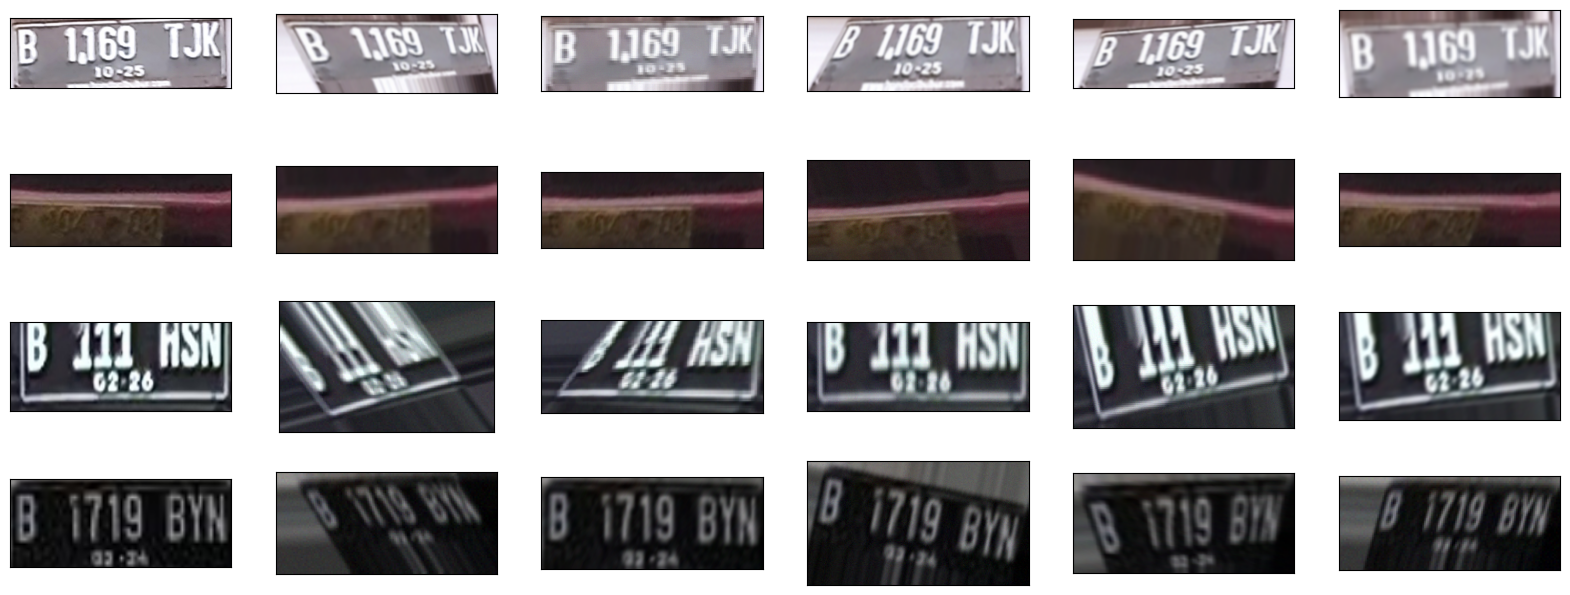

In [ ]:
df_train = pd.read_csv("dataframe/df_train.csv")
plt.figure(figsize=(20, 20))
i = 1
while i <= 20:
    nums = df_train["file_name"].str[10:-6].astype("int")
    n = np.random.choice(nums)
    data = df_train[nums == n]
    k = 0
    for j in range(i, i+len(data)):
            plt.subplot(10, 6, j)
            img = Image.open(os.path.join("img_preprocessed/augmented", data["file_name"].iloc[k]))
            plt.xticks([]), plt.yticks([])
            plt.imshow(img)
            k += 1
    i += 6

### Training Transformer OCR

In [ ]:
df_train = pd.read_csv("dataframe/df_train.csv")

In [ ]:
train_df, test_df = train_test_split(df_train, test_size=0.15, random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.shape, test_df.shape

((8506, 2), (1502, 2))

In [ ]:
class LPDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
train_dataset = LPDataset(root_dir='img_preprocessed/augmented/',
                          df=train_df,
                          processor=processor)
eval_dataset = LPDataset(root_dir='img_preprocessed/augmented/',
                         df=test_df,
                         processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT).to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
cer_metric = load_metric("cer")
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

def compute_acc(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    acc = []
    for i in range(len(label_str)):
        len_1 = len(label_str[i])
        len_2 = len(pred_str[i])
        min = np.min([len_1, len_2])

        salah = 0
        for j in range(min):
            if label_str[i][j] != pred_str[i][j]:
                salah += 1
        a = (9 - salah) / 9
        acc.append( a )

    avg_acc = sum(acc) / len(acc)
    return avg_acc

In [ ]:
def train():
    wandb.init(
        project="lp_recognition",
        name=f"{MODEL_CKPT}_{EPOCHS}epochs_{str(len(df_train))[:2]}k",
        config={
            "learning_rate": LR,
            "epochs": EPOCHS,
        }
    )
    config = wandb.config

    optimizer = AdamW(model.parameters(), lr=config.learning_rate)

    for epoch in range(config.epochs):
        # Train
        model.train()
        train_loss = 0.0
        total_batches = len(train_dataloader)

        progress_bar = tqdm(enumerate(train_dataloader), total=total_batches, desc=f"Epoch {epoch}")

        for batch_idx, batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Log metrics and loss per batch
            wandb.log({"Train Loss (Batch)": loss.item()})

        avg_train_loss = train_loss / total_batches
        print(f"Train Loss after epoch {epoch}:", avg_train_loss)
        wandb.log({"Train Loss": avg_train_loss})

        # Evaluate
        model.eval()
        valid_loss = 0.0
        valid_cer = 0.0
        valid_acc = 0.0

        progress_bar = tqdm(enumerate(eval_dataloader), total=len(eval_dataloader), desc="Validation")

        with torch.no_grad():
            for batch_idx, batch in progress_bar:
                batch = {k: v.to(device) for k, v in batch.items()}

                # Run batch generation
                outputs = model.generate(batch["pixel_values"])
                # Compute CER
                cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
                valid_cer += cer
                # Compute accuracy
                acc = compute_acc(pred_ids=outputs, label_ids=batch["labels"])
                valid_acc += acc

                # Compute validation loss
                outputs = model(**batch)
                loss = outputs.loss
                valid_loss += loss.item()

                # Log metrics per batch
                wandb.log({"Validation CER (Batch)": cer, "Validation Accuracy (Batch)": acc,
                           "Validation Loss (Batch)": loss.item()})

        avg_valid_loss = valid_loss / len(eval_dataloader)
        avg_valid_cer = valid_cer / len(eval_dataloader)
        avg_valid_acc = valid_acc / len(eval_dataloader)
        print("Val. Loss:", avg_valid_loss, "|", "Val. CER:", avg_valid_cer, "|", "Val. Accuracy:", avg_valid_acc)
        wandb.log({"Validation Loss": avg_valid_loss, "Validation CER": avg_valid_cer, "Validation Accuracy": avg_valid_acc})

    model.save_pretrained("model/")

In [ ]:
if RETRAIN == True and gpu_memory >= 16e9:
    train()
else:
    print("Downloading trained model...")
    import gdown
    gdown.download_folder(id="13i05X-ZPA85n0YxEASnd7emIdQdSc-Gc")
    clear_output()
    print("Download completed")

Download completed


In [ ]:
%wandb maulairfani/lp_recognition/avq3gfrc --height 720

### Test and Inference

In [ ]:
df_test = pd.read_csv(os.path.join(wd, "test/DataTest.csv"), sep=";")
df_test = df_test.drop("Unnamed: 0", axis=1)
df_test = df_test.head(int(AMOUNT_TEST_DATA * len(df_test)))
df_test["text"] = ["1"]*len(df_test)
df_test.columns = ["file_name", "text"]

test_dataset = LPDataset(root_dir='test/',
                          df=df_test,
                          processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=100)

len(df_test)

100

In [ ]:
model_trained = VisionEncoderDecoderModel.from_pretrained('model').to('cuda')

In [ ]:
%%time
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        outputs = model_trained.generate(batch["pixel_values"])
y_pred = processor.batch_decode(outputs, skip_special_tokens=True)

CPU times: user 40.7 s, sys: 520 ms, total: 41.2 s
Wall time: 48.4 s


LABEL di bawah ini hanya untuk melihat akurasi model. file submission berasal dari hasil prediksi model.

In [ ]:
LABEL = ['AD7034OE', 'A9388EX', 'B16TB', 'B1661TKZ', 'AD3772ABE', 'B1273UV', 'B1064TFR', 'B1395TJW', 'B1270RFD', 'B1736BYH', 'B1627BIE', 'B1678WZM', 'AD9313SS', 'B1036UL', 'B1801TZS', 'B1474TJS', 'B1939PU', 'B1260TZT', 'B1376TJO', 'B17QO', 'AB6328LZ', 'B1236PZM', 'AB8644PK', 'B1JKT', 'AA7084OD', 'B1131EKG', 'B1037UN', 'B1036UL', 'AD8820CB', 'A9192ZM', 'B0120KXT', 'B1643TRO', 'B1390TJU', 'AB2681VD', 'B1860EFT', 'A8749FS', 'B1566FON', 'B1063SJQ', 'B1254TFX', 'B1038JCY', 'AB4923UH', 'B1509UN', 'B1937TLP', 'B1202UL', 'B1026TMZ', 'B1724PYW', 'B1102SIV', 'AD7034OE', 'AB4352CX', 'B1895EJB', 'B1786UJT', 'B1549RFS', 'B1869EOF', 'B1713VX', 'B1063SPW', 'B1661TKZ', 'A8014VA', 'B1873YU', 'B1820UL', 'B1422BKI', 'AB5278XA', 'AD418U', 'B1157Y', 'B1233RFD', 'B1031NI', 'AD99JR', 'B1683SEY', 'AA7004QF', 'B1241SSW', 'B1632TJJ', 'B1907ELR', 'B1815TJQ', 'B1734UJN', 'B1743EYF', 'B1075QO', 'AB2933IN', 'B1523TJT', 'B1157SSL', 'B1713VX', 'B1361TJS', 'A9388EX', 'B1532NKY', 'B1800UYU', 'B1411TVE', 'AB3787KE', 'B1339RFD', 'B1903RFD', 'AB2958QH', 'AD418U', 'B1885TLP', 'B1634SSN', 'AB3511OH', 'B1726UUA', 'B1820TJV', 'B1619URB', 'B1285UL', 'AB8644PK', 'AG9718EG', 'B1509UN', 'B1408RX']

In [ ]:
df_submission = pd.read_csv("dataframe/df_submission.csv").drop("Unnamed: 0", axis=1)

In [ ]:
def accuracy_score(y_true, y_pred):
    acc = []
    for i in range(len(y_true)):
        len_1 = len(y_true[i])
        len_2 = len(y_pred[i])

        y_true[i] = y_true[i] + " " * (9 - len_1)
        y_pred[i] = y_pred[i] + " " * (9 - len_2)

        salah = 0
        for j in range(9):
            if y_true[i][j] != y_pred[i][j]:
                salah += 1
        a = (9 - salah) / 9
        acc.append( a )
    print(f"Accuracy: {round(sum(acc), 3)}%")

In [ ]:
# y_pred=df_submission["Vehicleregistrationplatebymodel"]
accuracy_score(y_true=LABEL, y_pred=y_pred)

Accuracy: 99.667%


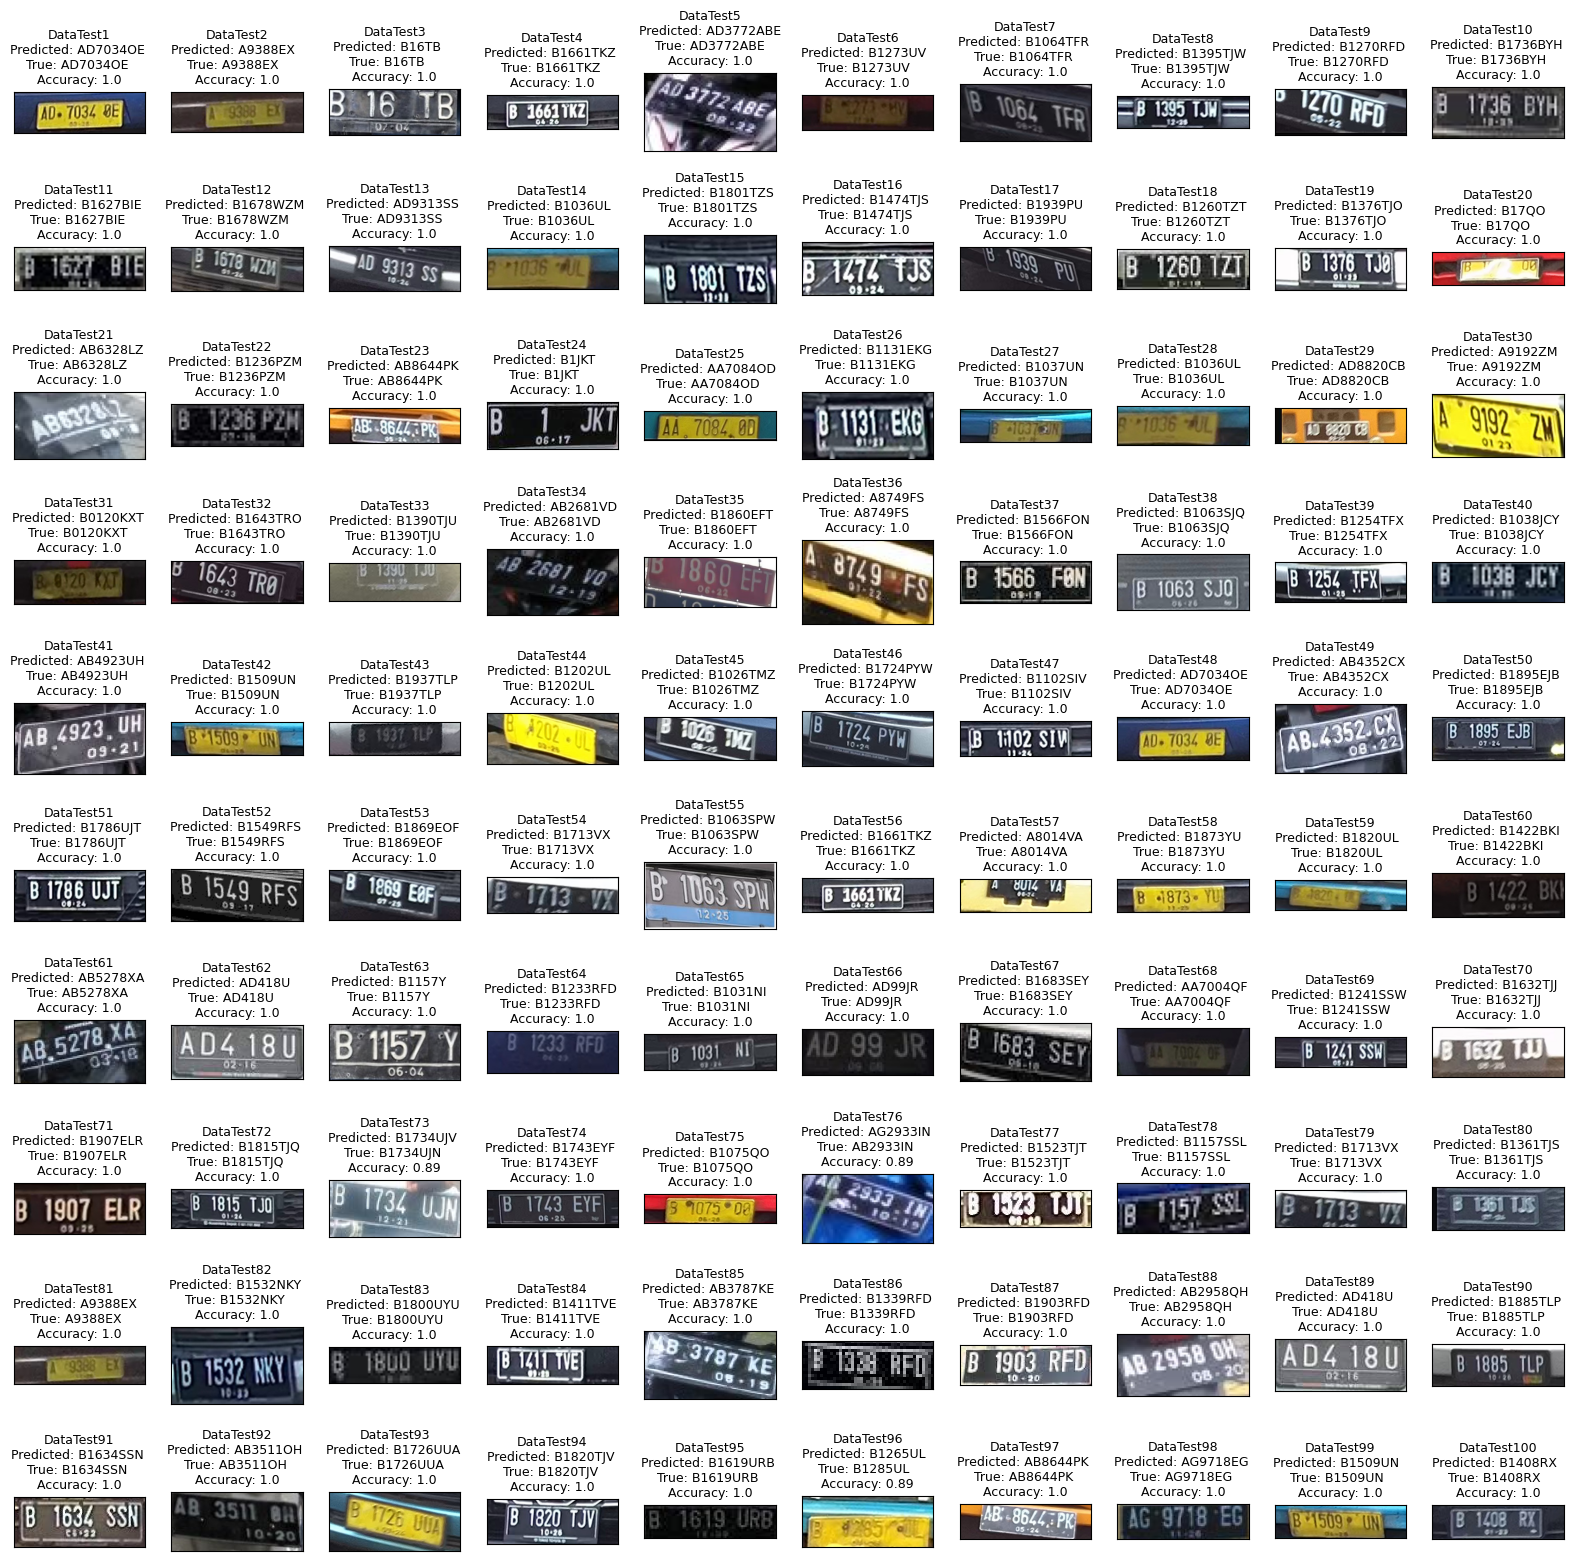

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(len(df_test)):
    img = Image.open(os.path.join("test", f"DataTest{i+1}.png")).convert("RGB")
    plt.subplot(10, 10, i+1)

    len_1 = len(LABEL[i])
    len_2 = len(y_pred[i])

    LABEL[i] = LABEL[i] + " " * (9 - len_1)
    y_pred[i] = y_pred[i] + " " * (9 - len_2)

    salah = 0
    for j in range(9):
        if LABEL[i][j] != y_pred[i][j]:
            salah += 1
    a = (9 - salah) / 9
    a = np.round(a, 2)

    plt.title(f"DataTest{i+1}\nPredicted: {y_pred[i]}\nTrue: {LABEL[i]}\nAccuracy: {a}", fontsize=9)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

In [ ]:
print("Running time:", time.time()-start)

Running time: 2802.2529847621918


In [ ]:
def predict_single_image(image_path):
    img = Image.open(image_path).convert("RGB")
    pixel_values = processor(img, return_tensors="pt").pixel_values
    generated_ids = model_trained.generate(pixel_values, max_length=9)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    plt.plot()
    plt.title("Predicted: " + generated_text)
    plt.imshow(img)

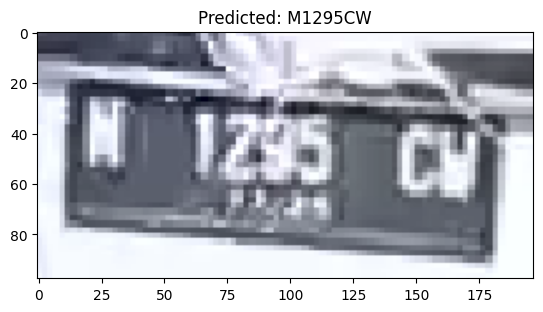

In [ ]:
predict_single_image("/content/Screenshot 2023-08-05 091741.png")

### Tes Data Baru Final
Asumsi diberikan file zip berisi gambar dan csv seperti data test

#### Prepare Dependencies and Load Model

In [ ]:
!pip install transformers -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00


In [ ]:
import zipfile
import os
import gdown
from transformers import TrOCRProcessor
from torch.utils.data import DataLoader
from transformers import VisionEncoderDecoderModel
import torch
from IPython.display import clear_output
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image

In [ ]:
# Cek Working directory
wd = os.getcwd()
os.chdir(wd)
print(wd)

/content


In [ ]:
# Download model & processor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-stage1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Downloading trained model...")
gdown.download_folder(id="13i05X-ZPA85n0YxEASnd7emIdQdSc-Gc")
clear_output()
print("Download completed")

model_trained = VisionEncoderDecoderModel.from_pretrained('model').to(device)

Download completed


#### Data Test

In [ ]:
import time
start = time.time()

In [ ]:
# Download zip dari google drive
!gdown 1t3uQsE1wOnl5ok7ZyQr7KzatzsJWoJ4y -q

In [ ]:
%%time
zip_path = "Data Test for BDC 2023 - Penyisihan.zip" # Seharusnya ini nanti diganti
folder_images = "TEST"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")
os.rename(zip_path.replace(".zip", ""), folder_images)

CPU times: user 26.5 ms, sys: 15.9 ms, total: 42.5 ms
Wall time: 42.4 ms


In [ ]:
class LPDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
%%time
df_test = pd.read_csv(os.path.join(wd, folder_images, "DataTest.csv"), sep=";")
df_test = df_test.drop("Unnamed: 0", axis=1)
df_test["text"] = ["1"]*len(df_test)
df_test.columns = ["file_name", "text"]

test_dataset = LPDataset(root_dir=folder_images+"/",
                          df=df_test,
                          processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=100)

len(df_test)

CPU times: user 6.66 ms, sys: 0 ns, total: 6.66 ms
Wall time: 20.1 ms


100

In [ ]:
%%time
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        outputs = model_trained.generate(batch["pixel_values"])
y_pred = processor.batch_decode(outputs, skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


CPU times: user 14 s, sys: 643 ms, total: 14.6 s
Wall time: 17.4 s


In [ ]:
submission = pd.DataFrame({
    "Name of File": df_test["file_name"],
    "Vehicleregistrationplatebymodel": y_pred
})

submission.to_csv("BDC_Archi_test.csv")
submission.head()

Name of File Vehicleregistrationplatebymodel
0  DataTest1.png                        AD7034OE
1  DataTest2.png                         A9388EX
2  DataTest3.png                           B16TB
3  DataTest4.png                        B1661TKZ
4  DataTest5.png                       AD3772ABE

In [ ]:
print("Running time:", time.time()-start)

Running time: 21.629349946975708


#### Visualize

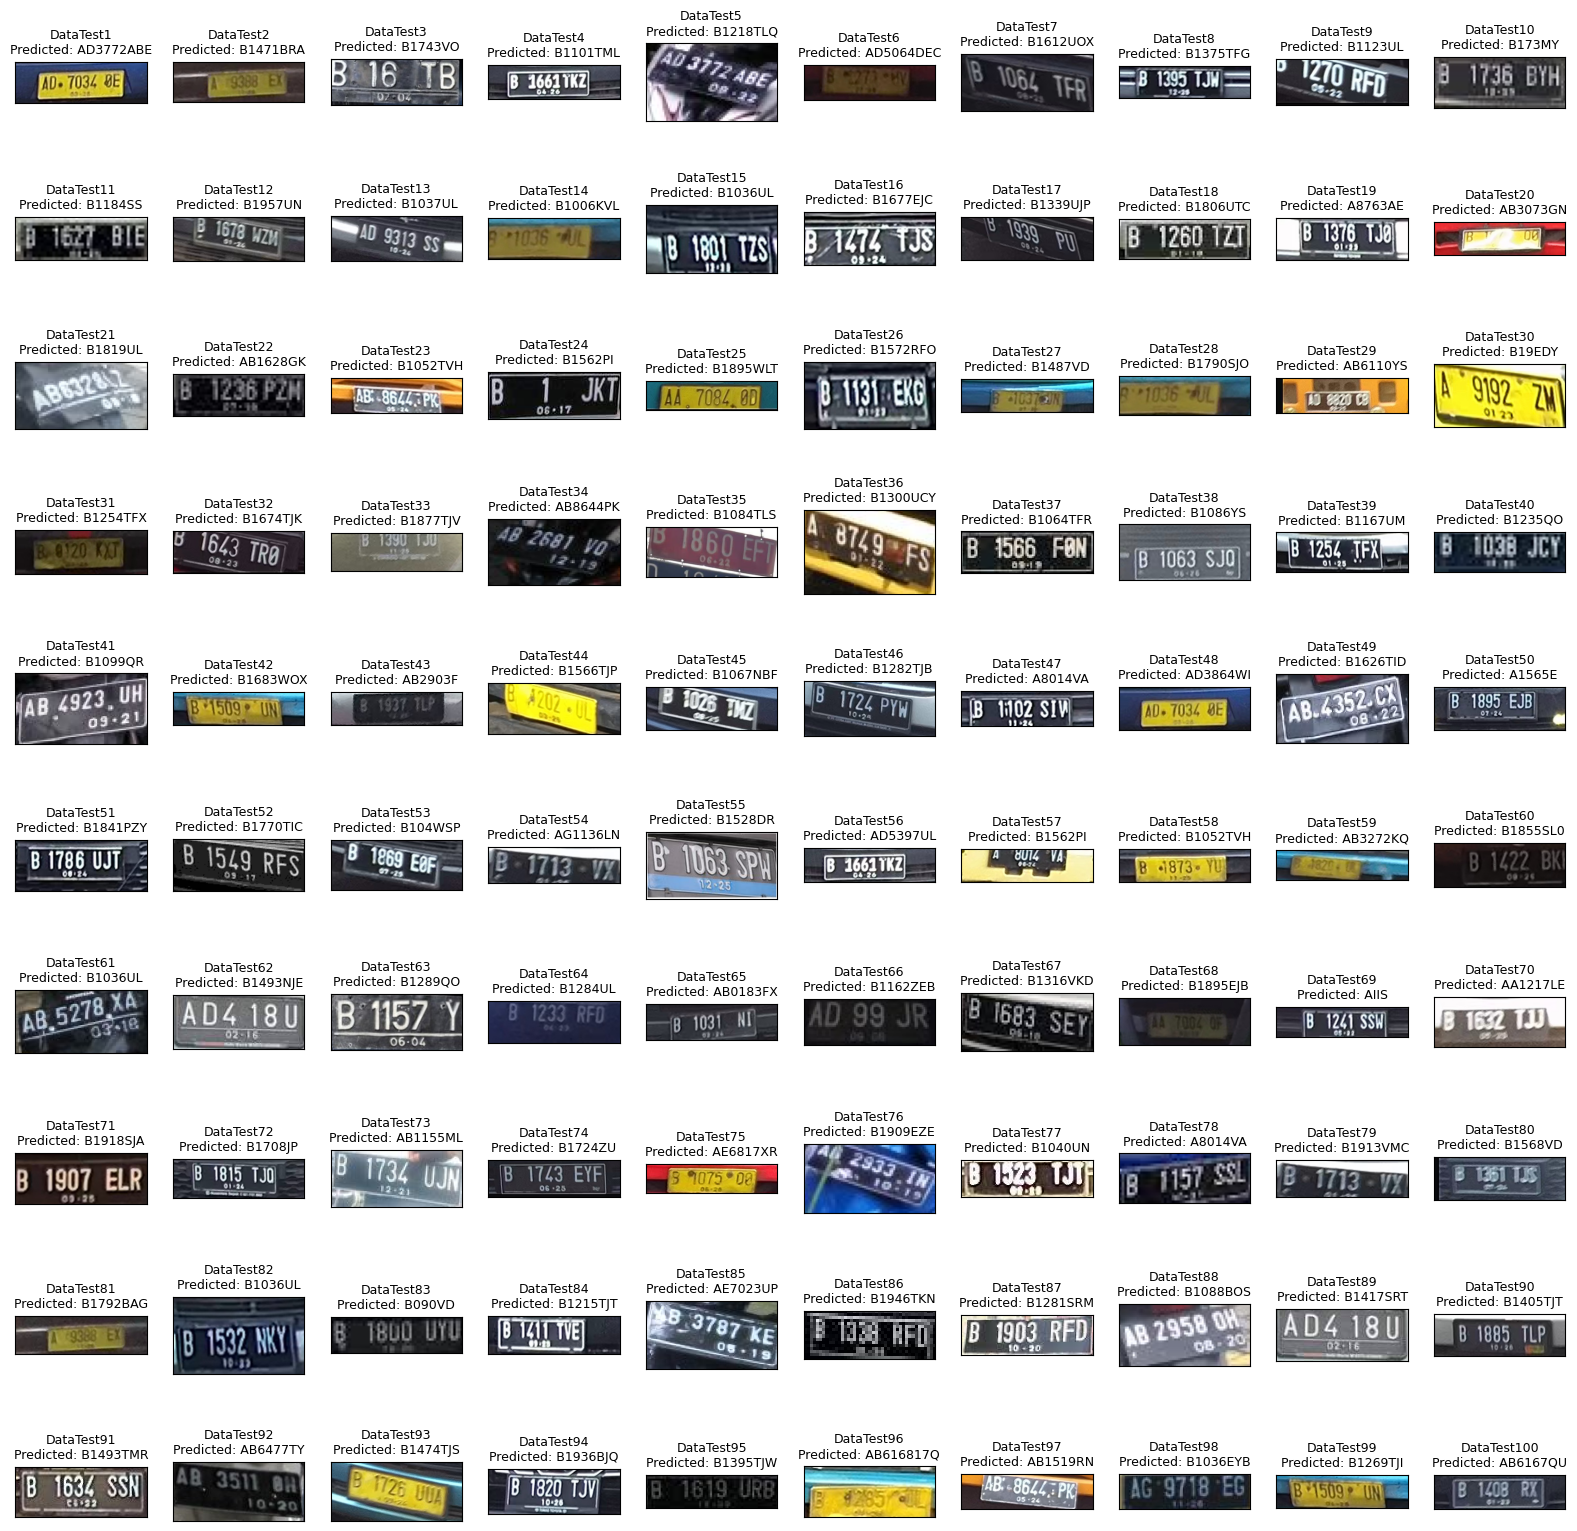

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
for i in range(len(df_test)):
    img = Image.open(os.path.join(folder_images, f"DataTest{i+1}.png")).convert("RGB")
    plt.subplot(10, 10, i+1)
    plt.title(f"DataTest{i+1}\nPredicted: {y_pred[i]}", fontsize=9)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

### Data Val

In [ ]:
start = time.time()

In [ ]:
# Download zip dari google drive
!gdown 1YO0DqBBlbugwhw4WJy8YjDEYOjzRcYtG -q

In [ ]:
%%time
zip_path = "Data Val Final BDC.zip" # Seharusnya ini nanti diganti
os.makedirs("VAL", exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("./VAL")
# os.rename(zip_path.replace(".zip", ""), folder_images)

CPU times: user 12.7 ms, sys: 8.79 ms, total: 21.5 ms
Wall time: 21.2 ms


In [ ]:
%%time
df_val = pd.read_csv(os.path.join("VAL", "DataValidation.csv"), sep=";")
df_val = df_val.drop("Unnamed: 0", axis=1)
df_val["text"] = ["1"]*len(df_val)
df_val.columns = ["file_name", "text"]

val_dataset = LPDataset(root_dir="/content/VAL/",
                          df=df_val,
                          processor=processor)
val_dataloader = DataLoader(val_dataset, batch_size=100)

len(df_val)

CPU times: user 3.86 ms, sys: 0 ns, total: 3.86 ms
Wall time: 3.7 ms


100

In [ ]:
%%time
with torch.no_grad():
    for batch_idx, batch in enumerate(val_dataloader):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        outputs = model_trained.generate(batch["pixel_values"])
y_pred = processor.batch_decode(outputs, skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


CPU times: user 12.7 s, sys: 223 ms, total: 12.9 s
Wall time: 10.1 s


In [ ]:
submission = pd.DataFrame({
    "Name of File": df_val["file_name"],
    "Vehicleregistrationplatebymodel": y_pred
})

submission.to_csv("BDC_Archi_Val.csv")
submission

Name of File Vehicleregistrationplatebymodel
0     DataVal1.png                       AD3772ABE
1     DataVal2.png                        B1471BRA
2     DataVal3.png                         B1743VO
3     DataVal4.png                        B1101TML
4     DataVal5.png                        B1218TLQ
..             ...                             ...
95   DataVal96.png                       AB616817Q
96   DataVal97.png                        AB1519RN
97   DataVal98.png                        B1036EYB
98   DataVal99.png                        B1269TJI
99  DataVal100.png                        AB6167QU

[100 rows x 2 columns]

In [ ]:
print("Running time:", time.time()-start)

Running time: 12.215617418289185


### Visualize Val

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
for i in range(len(df_val)):
    img = Image.open(os.path.join(folder_images, f"DataVal{i+1}.png")).convert("RGB")
    plt.subplot(10, 10, i+1)
    plt.title(f"DataVal{i+1}\nPredicted: {y_pred[i]}", fontsize=9)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

FileNotFoundError: ignored

<Figure size 2000x2000 with 0 Axes>